In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from typing import Iterable, Optional, Tuple
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPRegressor  # Alternativa a redes neuronales de TensorFlow
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer

In [2]:
#Carga de datos
ruta = 'Datos_Ventas_Stock_Calendario.csv'
datos_ventas_stock_calendario = pd.read_csv(ruta, sep=",")
datos_ventas_stock_calendario['idSecuencia'] = pd.to_datetime(datos_ventas_stock_calendario['idSecuencia'])
datos_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     653514 non-null  int64         
 1   idSecuencia  653514 non-null  datetime64[ns]
 2   udsVenta     653514 non-null  int64         
 3   udsStock     653514 non-null  int64         
 4   bolOpen      653514 non-null  int64         
 5   bolHoliday   653514 non-null  int64         
 6   isPromo      653514 non-null  int64         
 7   año          653514 non-null  int64         
 8   mes          653514 non-null  int64         
 9   dia          653514 non-null  int64         
 10  dia_semana   653514 non-null  int64         
 11  semana       653514 non-null  int64         
 12  semana_mes   653514 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 64.8 MB


# Outliers

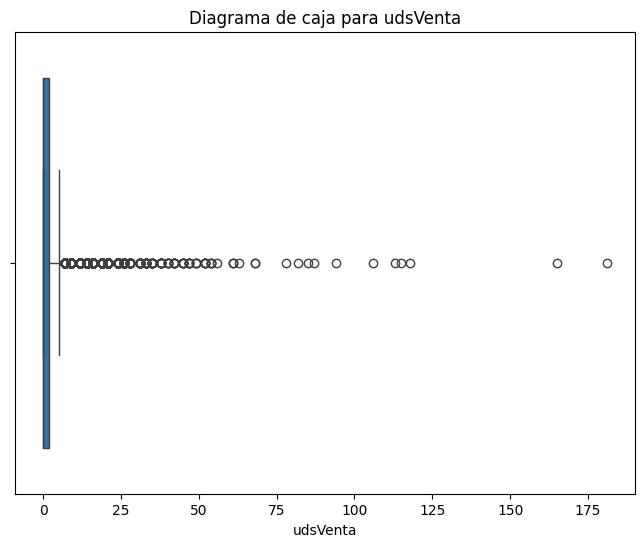

In [3]:

# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=datos_ventas_stock_calendario['udsVenta']) 
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

Para el tratamiento de valores atípicos se aplica un suavizado basado en medias móviles y desviaciones estándar calculadas por producto. Este enfoque contextualiza cada observación dentro de la dinámica temporal específica de la referencia, evitando mezclar comportamientos heterogéneos entre productos.

De esta manera, solo se corrigen valores inconsistentes respecto a la evolución histórica de cada artículo, preservando picos legítimos asociados a promociones, estacionalidad o variaciones naturales de la demanda.

In [4]:
df = datos_ventas_stock_calendario

df = df.sort_values(['producto', 'idSecuencia'])

# 1) medias y std rolling por producto
df['rolling_mean'] = df.groupby('producto')['udsVenta'].transform(
    lambda x: x.rolling(window=7, center=True, min_periods=1).mean()
)
df['rolling_std'] = df.groupby('producto')['udsVenta'].transform(
    lambda x: x.rolling(window=7, center=True, min_periods=1).std()
)

# 2) evitar std = 0
df['rolling_std'] = df['rolling_std'].replace(0, np.nan)

# 3) z-score contextual
df['z_context'] = (df['udsVenta'] - df['rolling_mean']) / df['rolling_std']

# 4) donde no podamos calcular z (NaN), NO tocamos el dato
cond_outlier = df['z_context'].abs() > 3

# si rolling_mean es NaN (bordes), también dejamos el valor original
df['udsVenta_suavizada'] = df['udsVenta']
df.loc[cond_outlier & df['rolling_mean'].notna(), 'udsVenta_suavizada'] = \
    df.loc[cond_outlier & df['rolling_mean'].notna(), 'rolling_mean']

df


,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,rolling_mean,rolling_std,z_context,udsVenta_suavizada
0,1,2022-11-06,0,148,0,1,1,2022,11,6,6,44,1,13.500000,11.474610,-1.176511,0
894,1,2022-11-07,12,148,1,0,1,2022,11,7,0,45,2,16.000000,11.401754,-0.350823,12
1788,1,2022-11-08,28,136,1,0,1,2022,11,8,1,45,2,17.333333,10.708252,0.996116,28
2682,1,2022-11-09,14,306,1,0,1,2022,11,9,2,45,2,19.285714,11.056134,-0.478080,14
3576,1,2022-11-10,26,291,1,0,1,2022,11,10,3,45,2,19.285714,11.056134,0.607291,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649937,1000,2024-11-01,0,24,1,1,0,2024,11,1,4,44,1,1.285714,2.627691,-0.489294,0
650831,1000,2024-11-02,0,24,1,0,0,2024,11,2,5,44,1,1.285714,2.627691,-0.489294,0
651725,1000,2024-11-03,0,24,0,1,0,2024,11,3,6,44,1,1.500000,2.810694,-0.533676,0
652619,1000,2024-11-04,7,24,1,0,0,2024,11,4,0,45,2,1.800000,3.033150,1.714389,7


In [5]:
df[df['udsVenta']!=df['udsVenta_suavizada']]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,rolling_mean,rolling_std,z_context,udsVenta_suavizada


En este caso vemos que no se corrige ninguno de los valores de venta, así que vamos a tomar los valores como correctos y no como outliers.

# Rotura de stock

Para identificar situaciones de rotura de stock, se considera que un producto presenta demanda habitual cuando ha registrado ventas positivas en al menos dos días distintos durante los 14 días previos en los que existía disponibilidad de inventario. Esta definición permite discriminar entre ausencia de ventas debida a falta de demanda y ventas censuradas por falta de stock.

In [6]:
def detectar_rotura_stock(
    df: pd.DataFrame,
    col_fecha: str = "idSecuencia",
    col_producto: str = "producto",
    col_venta: str = "udsVenta",
    col_stock: str = "udsStock",
    window_days: int = 14,
    min_dias_con_venta: int = 2,
) -> pd.DataFrame:
    out = df.copy()
    out[col_fecha] = pd.to_datetime(out[col_fecha])
    out = out.sort_values([col_producto, col_fecha]).reset_index(drop=False)

    # Evidencia de demanda (solo días con stock>0 y ventas>0)
    out["_evidencia_demanda"] = (
        (out[col_venta].fillna(0) > 0) &
        (out[col_stock].fillna(0) > 0)
    ).astype(int)

    def _rolling_prev_days(g: pd.DataFrame) -> pd.Series:
        g2 = g.sort_values(col_fecha).set_index(col_fecha)
        s = (
            g2["_evidencia_demanda"]
            .rolling(f"{window_days}D", min_periods=1)
            .sum()
            .shift(1)       # excluye el día actual
            .fillna(0)
        )
        s = s.reset_index(drop=True)
        s.index = g.index
        return s

    dias_col = f"dias_venta_pos_{window_days}d"
    dem_col  = f"demanda_habitual_{window_days}d"

    out[dias_col] = (
        out.groupby(col_producto, group_keys=False)
           .apply(_rolling_prev_days)
           .reset_index(level=0, drop=True)
           .astype(int)
    )

    out[dem_col] = out[dias_col] >= min_dias_con_venta

    # Rotura SOLO si no hay ventas (udsVenta==0)
    out["rotura_stock"] = (
        (out[col_stock].fillna(0) <= 0) &
        (out[col_venta].fillna(0) == 0) &
        out[dem_col]
    )

    out = (
        out.sort_values("index")
           .drop(columns=["_evidencia_demanda"])
           .set_index("index")
    )
    out.index.name = None
    return out

df = datos_ventas_stock_calendario.copy()
df2 = detectar_rotura_stock(df)

df2["rotura_stock"].mean()
df2.groupby("producto")["rotura_stock"].sum().describe()

# Ver roturas de stock
df2.loc[df2["rotura_stock"] == True, ['producto', 'idSecuencia', 'udsVenta', 'udsStock', 'rotura_stock']]


,producto,idSecuencia,udsVenta,udsStock,rotura_stock
6333,84,2022-11-13,0,0,True
6607,391,2022-11-13,0,0,True
9089,167,2022-11-16,0,0,True
9392,514,2022-11-16,0,0,True
9983,167,2022-11-17,0,0,True
...,...,...,...,...,...
652069,385,2024-11-04,0,0,True
652296,644,2024-11-04,0,0,True
652325,673,2024-11-04,0,0,True
652850,255,2024-11-05,0,0,True


Vemos que hay 4760 casos de rotura de stock. Se van a sustituir las unidades de venta por la media de las ventas de los últimos 14 días en estos casos.

In [7]:
def imputar_ventas_rotura_media_14d(
    df: pd.DataFrame,
    col_fecha: str = "idSecuencia",
    col_producto: str = "producto",
    col_venta: str = "udsVenta",
    col_stock: str = "udsStock",
    col_rotura: str = "rotura_stock",
    window_days: int = 14,
) -> pd.DataFrame:
    out = df.copy()

    out[col_fecha] = pd.to_datetime(out[col_fecha])
    out = out.sort_values([col_producto, col_fecha]).reset_index(drop=False)

    # Ventas válidas: solo cuando hay stock
    out["_venta_valida"] = out[col_venta].where(out[col_stock] > 0, np.nan)

    def _rolling_mean_prev_days(g: pd.DataFrame) -> pd.Series:
        g2 = g.sort_values(col_fecha).set_index(col_fecha)
        s = (
            g2["_venta_valida"]
            .rolling(f"{window_days}D", min_periods=1)
            .mean()
            .shift(1)  # excluye el día actual
        )
        s = s.reset_index(drop=True)
        s.index = g.index
        return s

    media_col = f"media_venta_{window_days}d"

    out[media_col] = (
        out.groupby(col_producto, group_keys=False)
           .apply(_rolling_mean_prev_days)
           .reset_index(level=0, drop=True)
    )

    # Imputación SOLO en rotura de stock
    out[col_venta + "_imputada"] = out[col_venta]
    mask_rotura = out[col_rotura].fillna(False)

    out.loc[mask_rotura, col_venta + "_imputada"] = (
        out.loc[mask_rotura, media_col]
        .fillna(0)  # por seguridad en primeros días
    )

    # Limpieza
    out = (
        out.sort_values("index")
           .drop(columns=["_venta_valida"])
           .set_index("index")
    )
    out.index.name = None

    return out

# 1. Detectar roturas
df2 = detectar_rotura_stock(df)

# 2. Imputar ventas censuradas
df3 = imputar_ventas_rotura_media_14d(df2)

df3[(df3['udsVenta_imputada'] < 0.5) & (df3['rotura_stock'] == True)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,dias_venta_pos_14d,demanda_habitual_14d,rotura_stock,media_venta_14d,udsVenta_imputada
49457,318,2022-12-31,0,0,1,0,0,2022,12,31,5,52,5,2,True,True,0.285714,0.285714
78611,938,2023-02-01,0,0,1,0,0,2023,2,1,2,5,1,3,True,True,0.428571,0.428571
78624,951,2023-02-01,0,0,1,0,0,2023,2,1,2,5,1,3,True,True,0.428571,0.428571
79505,938,2023-02-02,0,0,1,0,0,2023,2,2,3,5,1,2,True,True,0.307692,0.307692
79518,951,2023-02-02,0,0,1,0,0,2023,2,2,3,5,1,3,True,True,0.461538,0.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625988,206,2024-10-06,0,0,0,1,0,2024,10,6,6,40,1,2,True,True,0.363636,0.363636
626882,206,2024-10-07,0,0,1,0,0,2024,10,7,0,41,2,2,True,True,0.400000,0.400000
627776,206,2024-10-08,0,0,1,0,0,2024,10,8,1,41,2,2,True,True,0.444444,0.444444
628318,822,2024-10-08,0,0,1,0,0,2024,10,8,1,41,2,3,True,True,0.428571,0.428571


Existen algunos productos con rotura de stock pero con ventas imputadas menores a 0.5 unidades. Esto quiere decir que al redondear se van a quedar a 0, cuando deberían ser 1. Por lo tanto, se van a forzar estos casos a 1.

In [8]:
mask_rotura = df3["rotura_stock"]

df3.loc[mask_rotura, "udsVenta_imputada"] = (
    df3.loc[mask_rotura, "udsVenta_imputada"]
      .where(df3.loc[mask_rotura, "udsVenta_imputada"] >= 0.5, 1)
      .round()
      .astype(int)
)
df3[(df3['rotura_stock'] == True) & (df3['udsVenta_imputada'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,dias_venta_pos_14d,demanda_habitual_14d,rotura_stock,media_venta_14d,udsVenta_imputada
39414,87,2022-12-20,0,0,1,0,0,2022,12,20,1,51,4,2,True,True,0.5,0.0
48068,772,2022-12-29,0,0,1,0,0,2022,12,29,3,52,5,2,True,True,0.5,0.0
79929,408,2023-02-03,0,0,1,0,0,2023,2,3,4,5,1,3,True,True,0.5,0.0
80412,951,2023-02-03,0,0,1,0,0,2023,2,3,4,5,1,3,True,True,0.5,0.0
83530,438,2023-02-07,0,0,1,0,0,2023,2,7,1,6,2,2,True,True,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548815,894,2024-07-11,0,0,1,0,0,2024,7,11,3,28,2,2,True,True,0.5,0.0
559982,380,2024-07-24,0,0,1,0,0,2024,7,24,2,30,4,2,True,True,0.5,0.0
600240,413,2024-09-07,0,0,1,0,0,2024,9,7,5,36,2,3,True,True,0.5,0.0
628670,206,2024-10-09,0,0,1,0,0,2024,10,9,2,41,2,2,True,True,0.5,0.0


In [9]:
datos_ventas_stock_calendario_clean = datos_ventas_stock_calendario.merge(
    df3[['producto', 'idSecuencia', 'udsVenta_imputada']],
    on=['producto', 'idSecuencia'],
    how='left'
)

datos_ventas_stock_calendario_clean['udsVenta'] = datos_ventas_stock_calendario_clean['udsVenta_imputada']
datos_ventas_stock_calendario_clean = datos_ventas_stock_calendario_clean.drop(columns=['udsVenta_imputada'])
datos_ventas_stock_calendario_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     653514 non-null  int64         
 1   idSecuencia  653514 non-null  datetime64[ns]
 2   udsVenta     653514 non-null  float64       
 3   udsStock     653514 non-null  int64         
 4   bolOpen      653514 non-null  int64         
 5   bolHoliday   653514 non-null  int64         
 6   isPromo      653514 non-null  int64         
 7   año          653514 non-null  int64         
 8   mes          653514 non-null  int64         
 9   dia          653514 non-null  int64         
 10  dia_semana   653514 non-null  int64         
 11  semana       653514 non-null  int64         
 12  semana_mes   653514 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 64.8 MB


# Clustering

Con los datos que contamos tenemos 1000 productos. De esos 1000, hay muchos con demanda muy baja, alta intermitencia y estacionalidad semanal clara. Por lo tanto, vamos a aplicar clusterizado para que se pueda predecir la demanda de productos de los cuales tenemos pocas ventas. Con la predicción por producto individual lo más seguro es que solo funcionara correctamente para productos de alta rotación o con muchos datos.

Vamos a realizar varias aproximaciones de clustering para ver cual funciona mejor.

## K-means

En primer lugar, vamos a realizar el clustering con K-means.



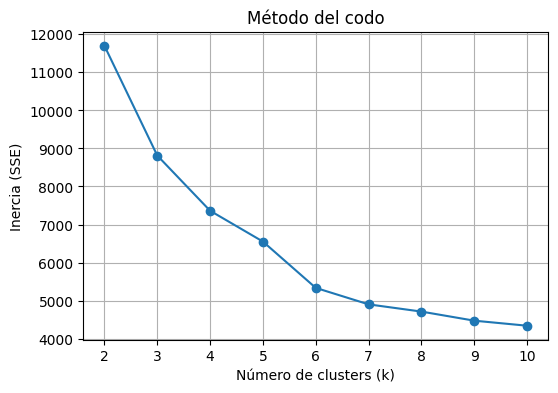

In [10]:
df = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()


# Agregamos por producto: estadísticas básicas de demanda
features = (
    df.groupby('producto')
      .agg(
          mean_udsVenta=('udsVenta', 'mean'),
          std_udsVenta=('udsVenta', 'std'),
          max_udsVenta=('udsVenta', 'max'),
          total_udsVenta=('udsVenta', 'sum'),
          dias_con_datos=('udsVenta', 'size'),
          dias_con_venta=('udsVenta', lambda x: (x > 0).sum())
      )
      .reset_index()
)

# % de días con venta > 0
features['pct_dias_con_venta'] = features['dias_con_venta'] / features['dias_con_datos']

# Coeficiente de variación (std / media), controlando media = 0
features['cv_udsVenta'] = features.apply(
    lambda row: row['std_udsVenta'] / row['mean_udsVenta'] if row['mean_udsVenta'] > 0 else 0,
    axis=1
)

# Ventas medias por día de la semana (0-6) para cada producto
dow = (
    df.groupby(['producto', 'dia_semana'])['udsVenta']
      .mean()
      .unstack(fill_value=0)
)
dow.columns = [f'uds_dow_{int(c)}' for c in dow.columns]  # uds_dow_0 ... uds_dow_6

# Ventas medias por mes (1-12) para cada producto
meses = (
    df.groupby(['producto', 'mes'])['udsVenta']
      .mean()
      .unstack(fill_value=0)
)
meses.columns = [f'uds_mes_{int(c)}' for c in meses.columns]  # uds_mes_1 ... uds_mes_12

# Unimos todo en features
features = (
    features
    .merge(dow, on='producto', how='left')
    .merge(meses, on='producto', how='left')
)

# Rellenamos posibles NaN (por si algún producto no vendió en cierto mes/día)
features = features.fillna(0)

# Guardamos productos y nos quedamos solo con columnas numéricas
productos = features['producto']
X = features.drop(columns=['producto'])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método del codo
inertia = []
K_range = range(2, 11)  # por ejemplo de 2 a 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo')
plt.grid(True)
plt.show()


In [11]:
k_optimo = 4 

features_kmeans = features.copy()

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init='auto')
features_kmeans['cluster'] = kmeans_final.fit_predict(X_scaled)

# Asignar el cluster de cada producto a todas sus filas en el dataset diario
df_clusters = df.merge(
    features_kmeans[['producto', 'cluster']],
    on='producto',
    how='left'
)

datos_ventas_stock_calendario_kmeans = df_clusters



In [12]:
# Resumen por cluster
resumen_clusters = (
    features_kmeans
    .groupby('cluster')
    [['mean_udsVenta', 'std_udsVenta', 'total_udsVenta', 'pct_dias_con_venta', 'cv_udsVenta']]
    .mean()
)

print(resumen_clusters)

# Número de productos por cluster
print(features_kmeans['cluster'].value_counts())


         mean_udsVenta  std_udsVenta  total_udsVenta  pct_dias_con_venta  \
cluster                                                                    
0             0.597286      1.651685      436.615970            0.189100   
1             2.407835      3.122407     1760.127273            0.533333   
2             4.402037      4.513152     3217.888889            0.685135   
3             1.234696      2.088758      902.563107            0.361999   

         cv_udsVenta  
cluster               
0           3.149529  
1           1.309671  
2           1.040939  
3           1.717327  
cluster
3    412
0    263
1    165
2     54
Name: count, dtype: int64


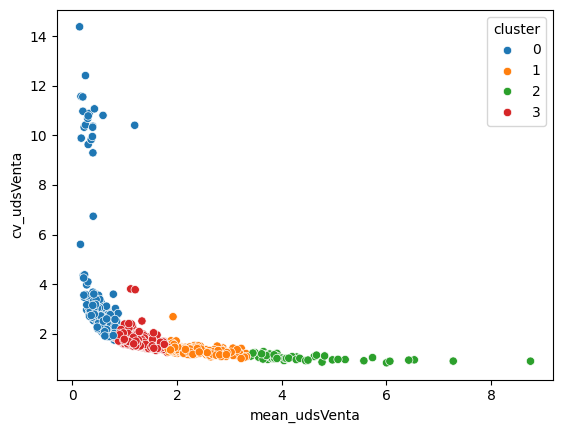

In [13]:
sns.scatterplot(
    data=features_kmeans,
    x='mean_udsVenta',
    y='cv_udsVenta',
    hue='cluster',
    palette='tab10'
)
plt.show()


Los cuatro clústeres identificados representan patrones de demanda bien diferenciados:

Cluster 0 — Rotación moderada y demanda estable
Demandan entre 1 y 2 unidades diarias con variabilidad baja-moderada.

Cluster 1 — Productos intermitentes de muy baja rotación
Representan artículos con venta esporádica y alta incertidumbre (CV elevado).

Cluster 2 — Alta rotación y demanda muy estable
Productos estratégicos cuya venta es constante y predecible.

Cluster 3 — Rotación media-alta y comportamiento estable
Patrones regulares con baja variabilidad, ligeramente por debajo del cluster 2.

## DBSCAN
Ideal si los datos tienen muchos outliers, clusters de formas no esféricas y densidades diferentes.

DBSCAN identifica puntos "densos" y separa los que no encajan → muy útil cuando hay productos con demanda muy irregular.


In [14]:
features_dbscan = features.copy()

X = StandardScaler().fit_transform(features)

dbscan = DBSCAN(eps=1.4, min_samples=5)
features_dbscan["cluster"] = dbscan.fit_predict(X)

features_dbscan


,producto,mean_udsVenta,std_udsVenta,max_udsVenta,total_udsVenta,dias_con_datos,dias_con_venta,pct_dias_con_venta,cv_udsVenta,uds_dow_0,...,uds_mes_4,uds_mes_5,uds_mes_6,uds_mes_7,uds_mes_8,uds_mes_9,uds_mes_10,uds_mes_11,uds_mes_12,cluster
0,1,8.749658,7.826998,49.0,6396.0,731,577,0.789330,0.894549,9.380952,...,6.583333,7.564516,11.800000,11.774194,10.548387,5.550000,8.790323,10.733333,9.209677,-1
1,2,7.274966,6.529358,42.0,5318.0,731,563,0.770178,0.897510,7.857143,...,5.850000,6.177419,8.566667,10.709677,7.467742,5.033333,6.483871,8.800000,8.306452,-1
2,3,5.212038,5.004400,26.0,3810.0,731,521,0.712722,0.960162,5.809524,...,4.566667,6.048387,5.750000,5.725806,5.419355,5.266667,5.532258,5.500000,4.612903,-1
3,4,3.013680,3.839924,26.0,2203.0,731,412,0.563611,1.274165,3.838095,...,2.683333,2.774194,3.800000,3.145161,2.806452,2.450000,3.225806,4.466667,2.758065,-1
4,5,3.771546,4.458461,26.0,2757.0,731,447,0.611491,1.182131,4.228571,...,2.816667,3.145161,5.516667,4.451613,3.354839,2.250000,3.854839,5.600000,3.645161,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,996,0.905609,1.776747,9.0,662.0,731,204,0.279070,1.961937,1.228571,...,1.350000,0.822581,1.450000,1.596774,0.967742,0.966667,1.000000,0.616667,0.548387,0
890,997,0.785226,1.514894,12.0,574.0,731,209,0.285910,1.929247,1.095238,...,0.766667,0.564516,0.416667,0.709677,0.693548,0.883333,1.209677,0.716667,1.225806,0
891,998,1.175103,1.871044,14.0,859.0,731,278,0.380301,1.592238,1.552381,...,1.700000,1.338710,1.016667,2.177419,1.145161,0.966667,1.338710,0.800000,0.919355,0
892,999,1.759234,2.767627,16.0,1286.0,731,312,0.426813,1.573200,2.095238,...,1.833333,1.709677,2.566667,3.725806,2.080645,1.383333,0.677419,1.116667,1.290323,-1


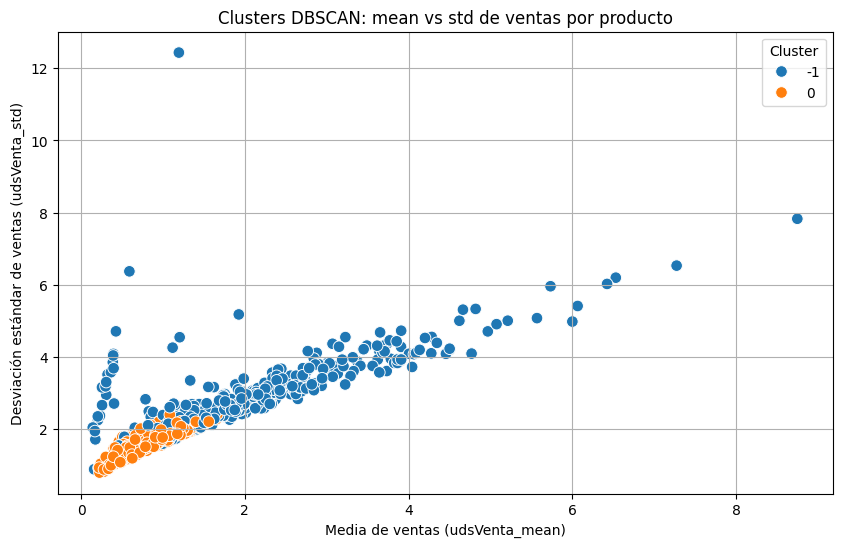

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_dbscan,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster",
    palette="tab10",
    s=70
)

plt.title("Clusters DBSCAN: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Con únicamente media y desviación estándar de ventas, DBSCAN no puede identificar clusters significativos porque los productos presentan una estructura continua sin zonas de alta densidad aisladas.

El único cluster bien formado corresponde a productos de baja rotación y baja variabilidad, pero la mayoría de las referencias quedan clasificadas como ruido.

## Gaussian Mixture Models (GMM)

Ventaja clave: permite clusters elípticos, solapados y con diferente forma.
Los outliers no son un problema.



In [16]:
features_gmm = features.copy()

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X)

features_gmm["cluster_gmm"] = labels_gmm


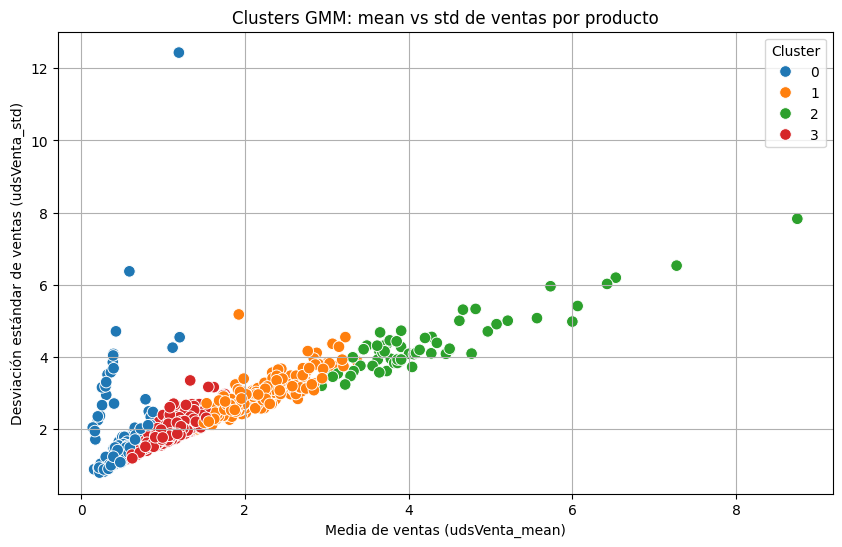

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_gmm,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster_gmm",
    palette="tab10",
    s=70
)

plt.title("Clusters GMM: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Los productos se segmentan en 4 comportamientos claros:
- 0 - Demanda: Baja, Variabilidad: Estable, Tipo de producto: Lento pero predecible
- 1 - Demanda: Muy baja, Variabilidad: Alta, Tipo de producto: Irregular, riesgo de rotura
- 2 - Demanda: Alta, Variabilidad: Alta, Tipo de producto: Críticos, alto impacto
- 3 - Demanda: Media, Variabilidad: Media, Tipo de producto: Intermedios

## K-Medoids (PAM — Partitioning Around Medoids)

Ventaja clave: Robusto a outliers (mucho más que K-Means).

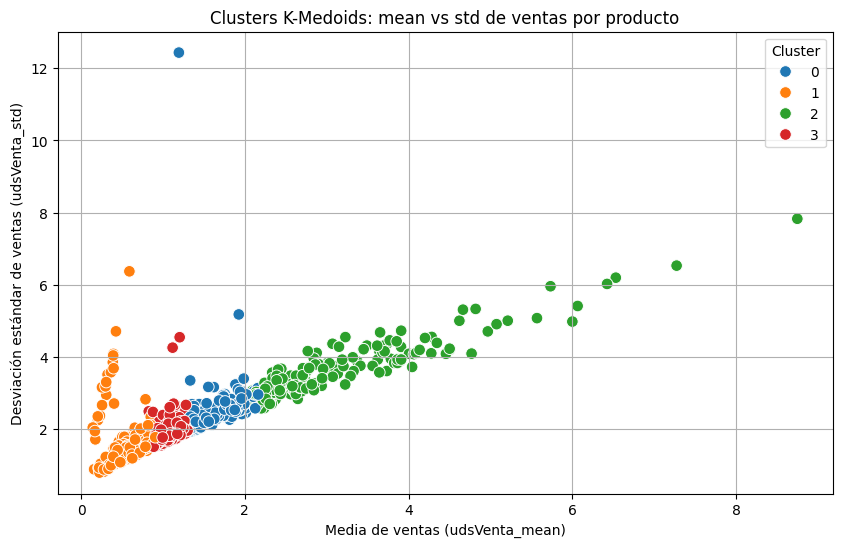

In [18]:
features_medoids = features.copy()
kmed = KMedoids(n_clusters=4, random_state=42)
labels_kmed = kmed.fit_predict(X)

features_medoids["cluster_kmed"] = labels_kmed

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_medoids,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster_kmed",
    palette="tab10",
    s=70
)

plt.title("Clusters K-Medoids: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()



Separa: 
Productos de alta rotación (verde)

Productos bajo-media rotación pero estables (azul)

Productos baja rotación pero muy volátiles (naranja)

Productos irregulares o atípicos (rojo)

Resultados muy parecidos a GMM.

# Entrenamiento de modelos

Vamos a realizar diferentes pruebas con diversos modelos para poder compararlos. Para ello, en primer lugar vamos a definir las métricas de comparación y definir una funcion para separar el dataset en entrenamiento y set.



In [19]:
df = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
# columnas:
# ['producto','idSecuencia','udsVenta','bolOpen','bolHoliday',
#  'isPromo','año','mes','dia','dia_semana','semana','semana_mes']

# --- métricas útiles ---
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def wmape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def metricas(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "wMAPE": wmape(y_true, y_pred),
        "EVS": explained_variance_score(y_true, y_pred)
    }

# --- split temporal train/valid ---
def temporal_train_val_test_split(
    df: pd.DataFrame,
    date_col: str,
    group_col: Optional[Iterable[str]] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split temporal con rangos fijos:
      - Train: 2022-11-05 .. 2023-12-31
      - Val:   2024-01-01 .. 2024-05-31
      - Test:  2024-06-01 .. 2024-11-06

    Si `group_col` se especifica (string o iterable de strings), el split
    se aplica dentro de cada grupo: para cada grupo se toman las filas cuya
    fecha cae en los rangos anteriores y luego se concatenan todos los grupos.
    Devuelve (train, val, test) como DataFrames ordenados por `group_col` y `date_col`.

    Parámetros
    - df: DataFrame de entrada.
    - date_col: nombre de la columna de fecha en `df`.
    - group_col: None, nombre de columna (str) o lista/tupla de nombres para agrupar.

    Notas
    - La comparación de fechas es inclusiva en los extremos.
    - La función no rellena ni mueve filas fuera de los rangos especificados.
    """
    if date_col not in df.columns:
        raise KeyError(f"date_col '{date_col}' no existe en el DataFrame")

    work = df.copy()
    work[date_col] = pd.to_datetime(work[date_col])

    # Rangos fijos (dd-mm-yyyy interpretado como ISO yyyy-mm-dd)
    train_start = pd.Timestamp("2022-11-05")
    train_end = pd.Timestamp("2023-12-31")
    val_start = pd.Timestamp("2024-01-01")
    val_end = pd.Timestamp("2024-05-31")
    test_start = pd.Timestamp("2024-06-01")
    test_end = pd.Timestamp("2024-11-06")

    # Normalizar group_col a lista si viene como str
    if group_col is None:
        sort_cols: List[str] = [date_col]
        # Filtro global por fechas (rápido)
        mask_train = (work[date_col] >= train_start) & (work[date_col] <= train_end)
        mask_val = (work[date_col] >= val_start) & (work[date_col] <= val_end)
        mask_test = (work[date_col] >= test_start) & (work[date_col] <= test_end)

        train = work.loc[mask_train].sort_values(sort_cols)
        val = work.loc[mask_val].sort_values(sort_cols)
        test = work.loc[mask_test].sort_values(sort_cols)
        return train, val, test

    # Si se especifica group_col, convertir a lista de columnas
    if isinstance(group_col, str):
        group_cols = [group_col]
    else:
        group_cols = list(group_col)

    sort_cols = group_cols + [date_col]

    # Construimos listas por grupo para luego concatenar
    train_parts = []
    val_parts = []
    test_parts = []

    # Iterar por grupos: preserve groups even if algunos no tienen filas en un rango
    grouped = work.groupby(group_cols, dropna=False)
    for _, grp in grouped:
        # Asegurar tipo fecha ya convertido
        g = grp.copy()
        mask_train = (g[date_col] >= train_start) & (g[date_col] <= train_end)
        mask_val = (g[date_col] >= val_start) & (g[date_col] <= val_end)
        mask_test = (g[date_col] >= test_start) & (g[date_col] <= test_end)

        t = g.loc[mask_train]
        v = g.loc[mask_val]
        te = g.loc[mask_test]

        if not t.empty:
            train_parts.append(t.sort_values(sort_cols))
        if not v.empty:
            val_parts.append(v.sort_values(sort_cols))
        if not te.empty:
            test_parts.append(te.sort_values(sort_cols))

    # Concatenar manteniendo índices originales
    train = pd.concat(train_parts, axis=0) if train_parts else work.iloc[0:0]
    val = pd.concat(val_parts, axis=0) if val_parts else work.iloc[0:0]
    test = pd.concat(test_parts, axis=0) if test_parts else work.iloc[0:0]

    # Orden final por grupo + fecha
    train = train.sort_values(sort_cols)
    val = val.sort_values(sort_cols)
    test = test.sort_values(sort_cols)

    return train, val, test

In [20]:
datos_ventas_stock_calendario_clean.to_csv('Datos_Ventas_Stock_Calendario_Clean.csv', index=False)

## Modelo por producto, pero mismo modelo para todos los productos. Datos preprocesados y sin clustering

In [21]:
def naive_model(
    df_prod,
    date_col="idSecuencia"
):
    df_prod = df_prod.sort_values(date_col)
    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,  # ya filtramos por producto antes
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None

    last_value = train['udsVenta'].iloc[-1]
    y_pred_val = np.full(len(val), last_value) if len(val) else np.array([])
    y_pred_test = np.full(len(test), last_value)

    res_val = metricas(val['udsVenta'], y_pred_val) if len(val) else None
    res_test = metricas(test['udsVenta'], y_pred_test)
    return res_test, res_val, train, val, test, y_pred_test

def naive_por_producto(df):
    resultados_test_globales = []
    resultados_val_globales = []
    y_true_test_global = []
    y_pred_test_global = []
    y_true_val_global = []
    y_pred_val_global = []
    preds_rows = []  # acumula dataset de test por producto

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()

        if len(df_prod) < 5:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test = naive_model(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global.extend(test["udsVenta"].values)
            y_pred_test_global.extend(y_pred_test)

            # dataset de test con métricas por fila
            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global.extend(val["udsVenta"].values)
                y_pred_val_global.extend(np.full(len(val), train["udsVenta"].iloc[-1]))

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global = np.array(y_true_test_global)
    y_pred_test_global = np.array(y_pred_test_global)
    y_true_val_global = np.array(y_true_val_global)
    y_pred_val_global = np.array(y_pred_val_global)

    metricas_globales_test = None
    if len(y_true_test_global) > 0:
        metricas_globales_test = metricas(y_true_test_global, y_pred_test_global)
        print("Métricas globales modelo Naive (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales (listas vacías).")

    metricas_globales_val = None
    if len(y_true_val_global) > 0:
        metricas_globales_val = metricas(y_true_val_global, y_pred_val_global)
        print("Métricas globales modelo Naive (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales de validación (listas vacías).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )
    # ahora devuelve métricas + dataset de test con predicciones
    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_naive, metricas_globales_val_naive, df_preds_test_naive = naive_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_naive.to_csv('Predicciones_Test_Naive_Clean.csv', index=False)

Métricas globales modelo Naive (TEST):
MSE: 33.5542
RMSE: 5.7926
MAE: 2.0850
MAPE: 94.0064
wMAPE: 1.4833
EVS: -3.8151
Métricas globales modelo Naive (VALIDACIÓN):
MSE: 32.6999
RMSE: 5.7184
MAE: 1.9699
MAPE: 93.8988
wMAPE: 1.5339
EVS: -4.3160


In [22]:
def moving_average_model(
    df_prod,
    window=7,
    date_col="idSecuencia"
):
    df_prod = df_prod.sort_values(date_col)
    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < window or len(test) == 0:
        return None, None, train, val, test, None, None

    mean_val = train['udsVenta'].tail(window).mean()
    y_pred_val = np.full(len(val), mean_val) if len(val) else np.array([])
    y_pred_test = np.full(len(test), mean_val)

    res_val = metricas(val['udsVenta'], y_pred_val) if len(val) else None
    res_test = metricas(test['udsVenta'], y_pred_test)
    return res_test, res_val, train, val, test, y_pred_test, y_pred_val

def moving_average_model_por_producto(df, window=7):
    resultados_test_globales = []
    resultados_val_globales = []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = moving_average_model(
                df_prod, window=window
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })
            y_true_test_global.extend(test["udsVenta"].values)
            y_pred_test_global.extend(y_pred_test)

            # dataset de test con métricas por fila
            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global.extend(val["udsVenta"].values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global = np.array(y_true_test_global)
    y_pred_test_global = np.array(y_pred_test_global)
    y_true_val_global = np.array(y_true_val_global)
    y_pred_val_global = np.array(y_pred_val_global)

    metricas_globales_test = None
    if len(y_true_test_global) > 0:
        metricas_globales_test = metricas(y_true_test_global, y_pred_test_global)
        print("Métricas globales modelo media móvil (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales (listas vacías).")

    metricas_globales_val = None
    if len(y_true_val_global) > 0:
        metricas_globales_val = metricas(y_true_val_global, y_pred_val_global)
        print("Métricas globales modelo media móvil (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales de validación (listas vacías).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    # devuelve métricas y dataset de test con predicciones
    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_moving_average, metricas_globales_val_moving_average, df_preds_test_moving_average = moving_average_model_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_moving_average.to_csv('Predicciones_Test_Moving_Average_Clean.csv', index=False)

Métricas globales modelo media móvil (TEST):
MSE: 7.7129
RMSE: 2.7772
MAE: 1.8236
MAPE: 64.1211
wMAPE: 1.2974
EVS: -0.1095
Métricas globales modelo media móvil (VALIDACIÓN):
MSE: 6.8587
RMSE: 2.6189
MAE: 1.7389
MAPE: 61.9999
wMAPE: 1.3540
EVS: -0.1041


In [23]:
def sarima_model_producto(
    df_prod,
    order=(1,1,1),
    seasonal_order=(0,1,1,7),
    min_len=30,
    date_col="idSecuencia"
):
    """
    Ajusta un SARIMA a la serie de un producto y devuelve m?tricas de test/val.
    """
    df_prod = df_prod.sort_values(date_col)

    if len(df_prod) < min_len:
        return None, None, df_prod, df_prod.iloc[0:0], df_prod.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < min_len or len(test) == 0:
        return None, None, train, val, test, None, None

    y_train = train['udsVenta']
    y_val = val['udsVenta']
    y_test = test['udsVenta']

    try:
        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        y_pred_test = res.forecast(steps=len(y_test))
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = None
        res_val = None
        if len(y_val) > 0:
            y_pred_val = res.get_prediction(start=len(y_train), end=len(y_train)+len(y_val)-1).predicted_mean
            res_val = metricas(y_val, y_pred_val)

        return res_test, res_val, train, val, test, np.array(y_pred_test), np.array(y_pred_val) if y_pred_val is not None else None

    except Exception as e:
        # si falla el ajuste, devolvemos None
        # print(f"Error SARIMA en producto: {e}")
        return None, None, train, val, test, None, None

def sarima_model_por_producto(df):
    resultados_test_globales_sarima = []
    resultados_val_globales_sarima = []
    y_true_test_global_sarima, y_pred_test_global_sarima = [], []
    y_true_val_global_sarima, y_pred_val_global_sarima = [], []
    preds_rows = []

    for prod_id in df['producto'].unique():
        df_prod = df[df['producto'] == prod_id].copy()

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = sarima_model_producto(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales_sarima.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global_sarima.extend(test['udsVenta'].values)
            y_pred_test_global_sarima.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0 and y_pred_val is not None:
                resultados_val_globales_sarima.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global_sarima.extend(val['udsVenta'].values)
                y_pred_val_global_sarima.extend(y_pred_val)

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global_sarima = np.array(y_true_test_global_sarima)
    y_pred_test_global_sarima = np.array(y_pred_test_global_sarima)
    y_true_val_global_sarima = np.array(y_true_val_global_sarima)
    y_pred_val_global_sarima = np.array(y_pred_val_global_sarima)

    if len(y_true_test_global_sarima) == 0:
        print("No se han generado predicciones globales SARIMA (test).")
        metricas_globales_test = None
    else:
        metricas_globales_test = metricas(y_true_test_global_sarima, y_pred_test_global_sarima)
        print("Métricas globales SARIMA (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_global_sarima) == 0:
        print("No se han generado predicciones globales SARIMA (validación).")
        metricas_globales_val = None
    else:
        metricas_globales_val = metricas(y_true_val_global_sarima, y_pred_val_global_sarima)
        print("Métricas globales SARIMA (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test



metricas_globales_test_sarima_clean, metricas_globales_val_sarima_clean, df_preds_test_sarima = sarima_model_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_sarima.to_csv('Predicciones_Test_SARIMA_Clean.csv', index=False)

Métricas globales SARIMA (TEST):
MSE: 7.6781
RMSE: 2.7709
MAE: 1.8364
MAPE: 65.8422
wMAPE: 1.3065
EVS: -0.1080
Métricas globales SARIMA (VALIDACIÓN):
MSE: 5.7807
RMSE: 2.4043
MAE: 1.5978
MAPE: 57.5562
wMAPE: 1.2442
EVS: 0.0645


In [24]:
def holtwinters_model_producto(
    df_prod,
    seasonal_periods=7,
    trend='add',
    seasonal='add',
    min_len=30,
    date_col="idSecuencia"
):
    """Ajusta Holt-Winters y devuelve metricas de test y validacion."""
    df_prod = df_prod.sort_values(date_col)

    if len(df_prod) < min_len:
        return None, None, df_prod, df_prod.iloc[0:0], df_prod.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < min_len or len(test) == 0:
        return None, None, train, val, test, None, None

    y_train = train['udsVenta']
    y_val = val['udsVenta']
    y_test = test['udsVenta']

    try:
        model = ExponentialSmoothing(
            y_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        )
        res = model.fit(optimized=True)

        y_pred_test = res.forecast(len(y_test))
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = np.array([])
        res_val = None
        if len(y_val) > 0:
            y_pred_val = res.forecast(len(y_val))
            res_val = metricas(y_val, y_pred_val)

        return res_test, res_val, train, val, test, np.array(y_pred_test), np.array(y_pred_val)

    except Exception:
        return None, None, train, val, test, None, None

def holtwinters_model_por_producto(df):
    resultados_test_globales_hw = []
    resultados_val_globales_hw = []
    y_true_test_global_hw, y_pred_test_global_hw = [], []
    y_true_val_global_hw, y_pred_val_global_hw = [], []
    preds_rows = []

    for prod_id in df['producto'].unique():
        df_prod = df[df['producto'] == prod_id].copy()

        if len(df_prod) < 30:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = holtwinters_model_producto(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales_hw.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global_hw.extend(test['udsVenta'].values)
            y_pred_test_global_hw.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales_hw.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global_hw.extend(val['udsVenta'].values)
                y_pred_val_global_hw.extend(y_pred_val)

        except Exception as e:
            print(f"Error Holt-Winters en producto {prod_id}: {e}")

    y_true_test_global_hw = np.array(y_true_test_global_hw)
    y_pred_test_global_hw = np.array(y_pred_test_global_hw)
    y_true_val_global_hw = np.array(y_true_val_global_hw)
    y_pred_val_global_hw = np.array(y_pred_val_global_hw)

    if len(y_true_test_global_hw) == 0:
        print("No se han generado predicciones globales Holt-Winters (test).")
        metricas_globales_test = None
    else:
        metricas_globales_test = metricas(y_true_test_global_hw, y_pred_test_global_hw)
        print("Metricas globales Holt-Winters (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_global_hw) == 0:
        print("No se han generado predicciones globales Holt-Winters (validacion).")
        metricas_globales_val = None
    else:
        metricas_globales_val = metricas(y_true_val_global_hw, y_pred_val_global_hw)
        print("Metricas globales Holt-Winters (VALIDACION):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_hw, metricas_globales_val_hw, df_preds_test_hw = holtwinters_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_hw.to_csv('Predicciones_Test_HoltWinters_Clean.csv', index=False)



Metricas globales Holt-Winters (TEST):
MSE: 7.6687
RMSE: 2.7692
MAE: 1.8300
MAPE: 65.5592
wMAPE: 1.3019
EVS: -0.1075
Metricas globales Holt-Winters (VALIDACION):
MSE: 5.8156
RMSE: 2.4115
MAE: 1.5978
MAPE: 57.1385
wMAPE: 1.2441
EVS: 0.0563


In [25]:
def preparar_features_producto(df_prod, max_lag=7):
    """
    Crea lags por producto y elimina filas con NaN generados.
    """
    g = df_prod.sort_values("idSecuencia").copy()
    for lag in range(1, max_lag + 1):
        g[f"lag_{lag}"] = g["udsVenta"].shift(lag)
    # features basicas de calendario + lags
    feature_cols = [
        "dia_semana","mes","semana","semana_mes",
        "bolOpen","bolHoliday","isPromo"
    ] + [f"lag_{i}" for i in range(1, max_lag + 1)]
    g = g.dropna()
    return g, feature_cols


def rf_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    rf_params=None,
    param_grid=None,          # dict con la rejilla
    metric_opt="RMSE"        # métrica a minimizar en la búsqueda
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    base_params = {"n_estimators": 200, "random_state": 42, "n_jobs": -1}
    if rf_params:
        base_params.update(rf_params)

    # Grid search sobre validación (o sobre train si no hay val)
    best_params = base_params.copy()
    if param_grid:
        search_target_X = X_val if len(X_val) > 0 else X_train
        search_target_y = y_val if len(X_val) > 0 else y_train

        best_score = np.inf
        for candidate in ParameterGrid(param_grid):
            trial_params = {**base_params, **candidate}
            trial_model = RandomForestRegressor(**trial_params)
            trial_model.fit(X_train, y_train)

            preds = trial_model.predict(search_target_X)
            score = metricas(search_target_y, preds)[metric_opt]
            if score < best_score:
                best_score = score
                best_params = trial_params

    # Entrenamos modelo final con los mejores params
    model = RandomForestRegressor(**best_params)
    model.fit(pd.concat([train, val])[feature_cols], pd.concat([train, val])["udsVenta"])

    y_pred_test = model.predict(X_test)
    res_test = metricas(y_test, y_pred_test)

    y_pred_val = np.array([])
    res_val = None
    if len(X_val) > 0:
        y_pred_val = model.predict(X_val)
        res_val = metricas(y_val, y_pred_val)

    return res_test, res_val, train, val, test, y_pred_test, y_pred_val

def rf_model_por_producto(df, rf_params=None, param_grid=None, metric_opt="wMAPE"):
    resultados_test_rf, resultados_val_rf = [], []
    y_true_test_rf, y_pred_test_rf = [], []
    y_true_val_rf, y_pred_val_rf = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = rf_model_producto(
                df_prod,
                rf_params=rf_params,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )
            if res_test is None or y_pred_test is None or len(test) == 0:
                continue
            
            # dataset de test por producto con errores por fila y métricas del producto

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            resultados_test_rf.append({**{"producto": prod_id}, **res_test})
            y_true_test_rf.extend(test["udsVenta"].values)
            y_pred_test_rf.extend(y_pred_test)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_rf.append({**{"producto": prod_id}, **res_val})
                y_true_val_rf.extend(val["udsVenta"].values)
                y_pred_val_rf.extend(y_pred_val)

        except Exception as e:
            print(f"Error RF en producto {prod_id}: {e}")

    # Métricas globales
    y_true_test_rf = np.array(y_true_test_rf)
    y_pred_test_rf = np.array(y_pred_test_rf)
    if len(y_true_test_rf) == 0:
        print("No se han generado predicciones globales RF (test).")
    else:
        metricas_test_global = metricas(y_true_test_rf, y_pred_test_rf)
        print("Metricas globales RF (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    y_true_val_rf = np.array(y_true_val_rf)
    y_pred_val_rf = np.array(y_pred_val_rf)
    if len(y_true_val_rf) == 0:
        print("No se han generado predicciones globales RF (validacion).")
    else:
        metricas_val_global = metricas(y_true_val_rf, y_pred_val_rf)
        print("Metricas globales RF (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")
    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )
    return metricas_test_global, metricas_val_global, df_preds_test

param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [200, 400],
}



In [26]:
metricas_globales_test_rf, metricas_globales_val_rf, df_preds_test_rf = rf_model_por_producto(datos_ventas_stock_calendario_clean, param_grid=param_grid, metric_opt="RMSE")
df_preds_test_rf.to_csv('Predicciones_Test_Random_Forest_Clean.csv', index=False)


Metricas globales RF (TEST):
MSE: 5.3794
RMSE: 2.3194
MAE: 1.4761
MAPE: 51.7035
wMAPE: 1.0501
EVS: 0.2241
Metricas globales RF (VALIDACION):
MSE: 2.1305
RMSE: 1.4596
MAE: 0.9412
MAPE: 36.8689
wMAPE: 0.7329
EVS: 0.6530


In [27]:
def xgb_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "n_estimators": [300, 600],
            "max_depth": [3, 6, 8],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "min_child_weight": [1, 5],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    xgb_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))  # minimizar

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        gs = GridSearchCV(
            XGBRegressor(
                objective="reg:squarederror",
                random_state=42,
                n_jobs=-1,
                tree_method="hist",
            ),
            param_grid=param_grid,
            scoring=xgb_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_xgb = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_xgb.fit(X_trainval, y_trainval, verbose=False)

        y_pred_test = best_xgb.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_xgb.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error XGB en producto: {e}")
        return None, None, train, val, test, None, None, None


def xgb_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_xgb = []
    resultados_val_xgb = []
    y_true_test_xgb, y_pred_test_xgb = [], []
    y_true_val_xgb, y_pred_val_xgb = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()

        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = xgb_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_xgb.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_xgb.extend(test["udsVenta"].values)
            y_pred_test_xgb.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_xgb.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_xgb.extend(val["udsVenta"].values)
                y_pred_val_xgb.extend(y_pred_val)

        except Exception as e:
            print(f"Error XGB en producto {prod_id}: {e}")

    y_true_test_xgb = np.array(y_true_test_xgb)
    y_pred_test_xgb = np.array(y_pred_test_xgb)
    y_true_val_xgb = np.array(y_true_val_xgb)
    y_pred_val_xgb = np.array(y_pred_val_xgb)

    if len(y_true_test_xgb) == 0:
        print("No se han generado predicciones globales XGB (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_xgb, y_pred_test_xgb)
        print("Metricas globales XGB (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_xgb) == 0:
        print("No se han generado predicciones globales XGB (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_xgb, y_pred_val_xgb)
        print("Metricas globales XGB (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test
metricas_globales_test_xgb, metricas_globales_val_xgb, df_preds_test_xgb = xgb_model_por_producto(datos_ventas_stock_calendario_clean, metric_opt="RMSE")
df_preds_test_xgb.to_csv('Predicciones_Test_XGB_Clean.csv', index=False)

Metricas globales XGB (TEST):
MSE: 6.3761
RMSE: 2.5251
MAE: 1.6182
MAPE: 60.0544
wMAPE: 1.1512
EVS: 0.0827
Metricas globales XGB (VALIDACION):
MSE: 1.0930
RMSE: 1.0455
MAE: 0.4830
MAPE: 19.1135
wMAPE: 0.3761
EVS: 0.8218


In [29]:
def mlp_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "mlp__hidden_layer_sizes": [(64, 32), (128, 64)],
            "mlp__activation": ["relu", "tanh"],
            "mlp__alpha": [1e-4, 1e-3],
            "mlp__learning_rate_init": [0.001, 0.01],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    mlp_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(max_iter=400, random_state=42)),
        ])
        gs = GridSearchCV(
            pipe,
            param_grid=param_grid,
            scoring=mlp_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_mlp = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_mlp.fit(X_trainval, y_trainval)

        y_pred_test = best_mlp.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_mlp.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error MLP en producto: {e}")
        return None, None, train, val, test, None, None, None


def mlp_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_mlp = []
    resultados_val_mlp = []
    y_true_test_mlp, y_pred_test_mlp = [], []
    y_true_val_mlp, y_pred_val_mlp = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = mlp_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_mlp.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_mlp.extend(test["udsVenta"].values)
            y_pred_test_mlp.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_mlp.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_mlp.extend(val["udsVenta"].values)
                y_pred_val_mlp.extend(y_pred_val)

        except Exception as e:
            print(f"Error MLP en producto {prod_id}: {e}")

    y_true_test_mlp = np.array(y_true_test_mlp)
    y_pred_test_mlp = np.array(y_pred_test_mlp)
    y_true_val_mlp = np.array(y_true_val_mlp)
    y_pred_val_mlp = np.array(y_pred_val_mlp)

    if len(y_true_test_mlp) == 0:
        print("No se han generado predicciones globales MLP (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_mlp, y_pred_test_mlp)
        print("Metricas globales MLP (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_mlp) == 0:
        print("No se han generado predicciones globales MLP (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_mlp, y_pred_val_mlp)
        print("Metricas globales MLP (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test

metricas_globales_test_mlp, metricas_globales_val_mlp, df_preds_test_mlp = mlp_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_mlp.to_csv('Predicciones_Test_MLP_Clean.csv', index=False)


Metricas globales MLP (TEST):
MSE: 7.8043
RMSE: 2.7936
MAE: 1.8447
MAPE: 73.4482
wMAPE: 1.3123
EVS: -0.1265
Metricas globales MLP (VALIDACION):
MSE: 1.1859
RMSE: 1.0890
MAE: 0.6122
MAPE: 26.6663
wMAPE: 0.4767
EVS: 0.8066


In [ ]:
def lgbm_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    lgbm_params=None,
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.5,
    )
    if lgbm_params:
        base_params.update(lgbm_params)

    # 1) Entrenamos para medir validación
    model = LGBMRegressor(**base_params)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val) if len(val) else np.array([])
    res_val = metricas(y_val, y_pred_val) if len(val) else None

    # 2) Reentrenamos con train+val para predecir test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    model.fit(X_trainval, y_trainval)

    y_pred_test = model.predict(X_test)
    res_test = metricas(y_test, y_pred_test)

    return res_test, res_val, train, val, test, y_pred_test, y_pred_val, base_params


def lgbm_model_por_producto(df, lgbm_params=None):
    resultados_test, resultados_val = [], []
    y_true_test, y_pred_test = [], []
    y_true_val, y_pred_val = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_hat_test, y_hat_val, used_params = lgbm_model_producto(
                df_prod,
                lgbm_params=lgbm_params,
            )
            if res_test is None or y_hat_test is None or len(test) == 0:
                continue

            resultados_test.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "params": used_params,
            })
            y_true_test.extend(test["udsVenta"].values)
            y_pred_test.extend(y_hat_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_hat_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_hat_val) > 0:
                resultados_val.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "params": used_params,
                })
                y_true_val.extend(val["udsVenta"].values)
                y_pred_val.extend(y_hat_val)

        except Exception as e:
            print(f"Error LGBM en producto {prod_id}: {e}")

    y_true_test = np.array(y_true_test)
    y_pred_test = np.array(y_pred_test)
    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)

    if len(y_true_test) == 0:
        print("No se han generado predicciones globales LGBM (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test, y_pred_test)
        print("Metricas globales LGBM (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val) == 0:
        print("No se han generado predicciones globales LGBM (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val, y_pred_val)
        print("Metricas globales LGBM (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test


metricas_globales_test_lgbm, metricas_globales_val_lgbm, df_preds_test_lgbm = lgbm_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_lgbm.to_csv('Predicciones_Test_LGBM_Clean.csv', index=False)                                                                                                                                                                                                                                                                                         

Metricas globales LGBM (TEST):
MSE: 7.8056
RMSE: 2.7939
MAE: 1.8625
MAPE: 70.2856
wMAPE: 1.3251
EVS: -0.1207
Metricas globales LGBM (VALIDACION):
MSE: 8.5086
RMSE: 2.9170
MAE: 1.9829
MAPE: 74.2705
wMAPE: 1.5440
EVS: -0.3635


In [ ]:
def dt_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["auto", "sqrt", "log2", None],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    dt_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        gs = GridSearchCV(
            DecisionTreeRegressor(random_state=42),
            param_grid=param_grid,
            scoring=dt_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_dt = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_dt.fit(X_trainval, y_trainval)

        y_pred_test = best_dt.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_dt.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error DT en producto: {e}")
        return None, None, train, val, test, None, None, None


def dt_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_dt = []
    resultados_val_dt = []
    y_true_test_dt, y_pred_test_dt = [], []
    y_true_val_dt, y_pred_val_dt = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = dt_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_dt.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_dt.extend(test["udsVenta"].values)
            y_pred_test_dt.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_dt.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_dt.extend(val["udsVenta"].values)
                y_pred_val_dt.extend(y_pred_val)

        except Exception as e:
            print(f"Error DT en producto {prod_id}: {e}")

    y_true_test_dt = np.array(y_true_test_dt)
    y_pred_test_dt = np.array(y_pred_test_dt)
    y_true_val_dt = np.array(y_true_val_dt)
    y_pred_val_dt = np.array(y_pred_val_dt)

    if len(y_true_test_dt) == 0:
        print("No se han generado predicciones globales DT (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_dt, y_pred_test_dt)
        print("Metricas globales DT (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_dt) == 0:
        print("No se han generado predicciones globales DT (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_dt, y_pred_val_dt)
        print("Metricas globales DT (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test

metricas_globales_test_dt, metricas_globales_val_dt, df_preds_test_dt = dt_model_por_producto(datos_ventas_stock_calendario_clean)   
df_preds_test_dt.to_csv('Predicciones_Test_DT_Clean.csv', index=False)


KeyboardInterrupt: 

## Modelo por producto, mismo modelo para todos los productos pero añadiendo la información de cluster

In [ ]:
#Añadimos al dataset el cluster de GMM

datos_ventas_stock_calendario_clean_cluster_gmm = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
datos_ventas_stock_calendario_clean_cluster_gmm  = datos_ventas_stock_calendario_clean_cluster_gmm.merge(
    features_gmm[['producto', 'cluster_gmm']],
    on=['producto'],
    how='left'
)

datos_ventas_stock_calendario_clean_cluster_gmm

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,cluster_gmm
0,1,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
1,2,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
2,3,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
3,4,2022-11-06,0,0,1,1,2022,11,6,6,44,1,0
4,5,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653509,996,2024-11-05,0,1,0,0,2024,11,5,1,45,2,3
653510,997,2024-11-05,0,1,0,0,2024,11,5,1,45,2,3
653511,998,2024-11-05,2,1,0,1,2024,11,5,1,45,2,3
653512,999,2024-11-05,0,1,0,0,2024,11,5,1,45,2,0


In [ ]:
# Evaluar mismos modelos:
metricas_globales_test_sarima_clean_gmm, metricas_globales_val_sarima_clean_gmm, df_preds_test_sarima_clean_gmm =  sarima_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_sarima_clean_gmm.to_csv('Predicciones_Test_SARIMA_Clean_GMM.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [ ]:
metricas_globales_test_rf_clean_gmm, metricas_globales_val_rf_clean_gmm, df_preds_test_rf_clean_gmm = rf_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_rf_clean_gmm.to_csv('Predicciones_Test_RF_Clean_GMM.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [ ]:
metricas_globales_test_xgb_clean_gmm, metricas_globales_val_xgb_clean_gmm, df_preds_test_xgb_clean_gmm = xgb_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_xgb_clean_gmm.to_csv('Predicciones_Test_XGB_Clean_GMM.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [ ]:
metricas_globales_test_mlp_clean_gmm, metricas_globales_val_mlp_clean_gmm, df_preds_test_mlp_clean_gmm = mlp_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_mlp_clean_gmm.to_csv('Predicciones_Test_MLP_Clean_GMM.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [ ]:
metricas_globales_test_lgbm_clean_gmm, metricas_globales_val_lgbm_clean_gmm, df_preds_test_lgbm_clean_gmm = lgbm_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_lgbm_clean_gmm.to_csv('Predicciones_Test_LGBM_Clean_GMM.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [ ]:
metricas_globales_test_dt_clean_gmm, metricas_globales_val_dt_clean_gmm, df_preds_test_dt_clean_gmm = dt_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_dt_clean_gmm.to_csv('Predicciones_Test_DT_Clean_GMM.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

In [ ]:
#Añadimos al dataset el cluster de K-means

datos_ventas_stock_calendario_clean_cluster_kmeans = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
datos_ventas_stock_calendario_clean_cluster_kmeans  = datos_ventas_stock_calendario_clean_cluster_kmeans.merge(
    features_kmeans[['producto', 'cluster']],
    on=['producto'],
    how='left'
)

datos_ventas_stock_calendario_clean_cluster_kmeans

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,cluster
0,1,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
1,2,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
2,3,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
3,4,2022-11-06,0,0,1,1,2022,11,6,6,44,1,3
4,5,2022-11-06,0,0,1,1,2022,11,6,6,44,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653509,996,2024-11-05,0,1,0,0,2024,11,5,1,45,2,1
653510,997,2024-11-05,0,1,0,0,2024,11,5,1,45,2,1
653511,998,2024-11-05,2,1,0,1,2024,11,5,1,45,2,1
653512,999,2024-11-05,0,1,0,0,2024,11,5,1,45,2,0


In [ ]:
metricas_globales_test_sarima_clean_kmeans, metricas_globales_val_sarima_clean_kmeans, df_preds_test_sarima_clean_kmeans =  sarima_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_sarima_clean_kmeans.to_csv('Predicciones_Test_SARIMA_Clean_KMEANS.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [ ]:
metricas_globales_test_rf_clean_kmeans, metricas_globales_val_rf_clean_kmeans, df_preds_test_rf_clean_kmeans = rf_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_rf_clean_kmeans.to_csv('Predicciones_Test_RF_Clean_KMEANS.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [ ]:
metricas_globales_test_xgb_clean_kmeans, metricas_globales_val_xgb_clean_kmeans, df_preds_test_xgb_clean_kmeans = xgb_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_xgb_clean_kmeans.to_csv('Predicciones_Test_XGB_Clean_KMEANS.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [ ]:
metricas_globales_test_mlp_clean_kmeans, metricas_globales_val_mlp_clean_kmeans, df_preds_test_mlp_clean_kmeans = mlp_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_mlp_clean_kmeans.to_csv('Predicciones_Test_MLP_Clean_KMEANS.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [ ]:
metricas_globales_test_lgbm_clean_kmeans, metricas_globales_val_lgbm_clean_kmeans, df_preds_test_lgbm_clean_kmeans = lgbm_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_lgbm_clean_kmeans.to_csv('Predicciones_Test_LGBM_Clean_KMEANS.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [ ]:
metricas_globales_test_dt_clean_kmeans, metricas_globales_val_dt_clean_kmeans, df_preds_test_dt_clean_kmeans = dt_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_dt_clean_kmeans.to_csv('Predicciones_Test_DT_Clean_KMEANS.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

## Datos sin limpieza y sin cluster

In [ ]:
datos_ventas_stock_calendario_not_clean = datos_ventas_stock_calendario.drop(columns=['udsStock']).copy()

In [ ]:
metricas_globales_test_sarima_not_clean, metricas_globales_val_sarima_not_clean, df_preds_test_sarima_not_clean =  sarima_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_sarima_not_clean.to_csv('Predicciones_Test_SARIMA_Not_Clean.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [ ]:
metricas_globales_test_rf_not_clean, metricas_globales_val_rf_not_clean, df_preds_test_rf_not_clean = rf_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_rf_not_clean.to_csv('Predicciones_Test_RF_Not_Clean.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [ ]:
metricas_globales_test_xgb_not_clean, metricas_globales_val_xgb_not_clean, df_preds_test_xgb_not_clean = xgb_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_xgb_not_clean.to_csv('Predicciones_Test_XGB_Not_Clean.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [ ]:
metricas_globales_test_mlp_not_clean, metricas_globales_val_mlp_not_clean, df_preds_test_mlp_not_clean = mlp_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_mlp_not_clean.to_csv('Predicciones_Test_MLP_Not_Clean.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [ ]:
metricas_globales_test_lgbm_not_clean, metricas_globales_val_lgbm_not_clean, df_preds_test_lgbm_not_clean = lgbm_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_lgbm_not_clean.to_csv('Predicciones_Test_LGBM_Not_Clean.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [ ]:
metricas_globales_test_dt_not_clean, metricas_globales_val_dt_not_clean, df_preds_test_dt_not_clean = dt_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_dt_not_clean.to_csv('Predicciones_Test_DT_Not_Clean.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

## Modelo por producto, cada producto el mejor modelo. Preprocesado y sin cluster

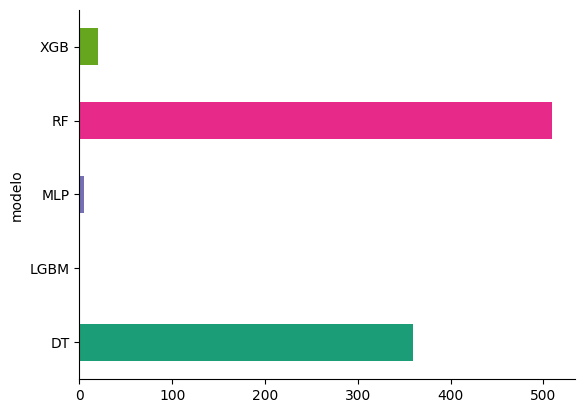

In [ ]:
df_preds_test_rf['modelo'] = 'RF'
df_preds_test_xgb['modelo'] = 'XGB'
df_preds_test_mlp['modelo'] = 'MLP'
df_preds_test_lgbm['modelo'] = 'LGBM'
df_preds_test_dt['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds = pd.concat([
    df_preds_test_rf.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds = df_all_preds.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product = df_all_preds.loc[df_all_preds.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product = best_models_per_product.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product.to_csv('Mejores_Modelos_por_Producto.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modelo por producto, el mejor para cada producto. Preprocesado y con cluster

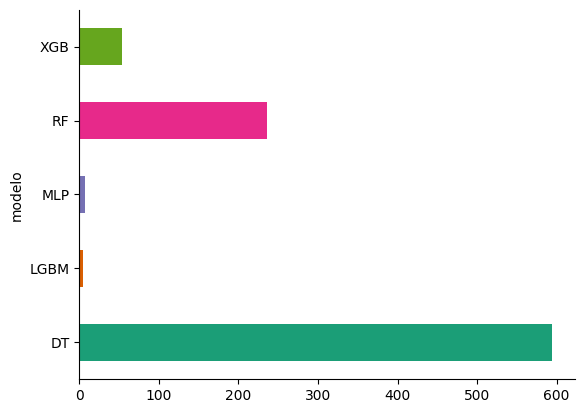

In [ ]:
#kmeans clean
df_preds_test_rf_clean_kmeans['modelo'] = 'RF'
df_preds_test_xgb_clean_kmeans['modelo'] = 'XGB'
df_preds_test_mlp_clean_kmeans['modelo'] = 'MLP'
df_preds_test_lgbm_clean_kmeans['modelo'] = 'LGBM'
df_preds_test_dt_clean_kmeans['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_clean_kmeans = pd.concat([
    df_preds_test_rf_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_clean_kmeans = df_all_preds_clean_kmeans.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product_kmeans = df_all_preds_clean_kmeans.loc[df_all_preds_clean_kmeans.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product_kmeans = best_models_per_product_kmeans.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product_kmeans.to_csv('Mejores_Modelos_por_Producto_Kmeans.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product_kmeans.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

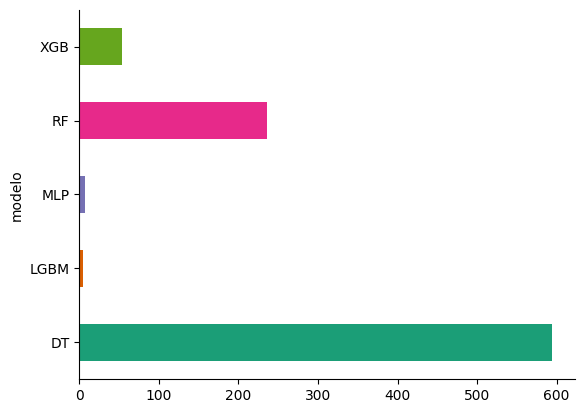

In [ ]:
#gmm clean
df_preds_test_rf_clean_gmm['modelo'] = 'RF'
df_preds_test_xgb_clean_gmm['modelo'] = 'XGB'
df_preds_test_mlp_clean_gmm['modelo'] = 'MLP'
df_preds_test_lgbm_clean_gmm['modelo'] = 'LGBM'
df_preds_test_dt_clean_gmm['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_clean_gmm = pd.concat([
    df_preds_test_rf_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_clean_gmm = df_all_preds_clean_gmm.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product_gmm= df_all_preds_clean_gmm.loc[df_all_preds_clean_gmm.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product_gmm = best_models_per_product_gmm.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product_gmm.to_csv('Mejores_Modelos_por_Producto_Gmm.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product_gmm.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modelo por cluster. Todos los clusters mismo modelo. Datos limpios

In [ ]:
def rf_model_cluster(
    df_cluster,
    max_lag=7,
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
    min_train_rows=1,
):
    """
    Entrena un RF para un cluster dado, usando features por producto dentro del cluster.
    Devuelve métricas test/val, splits y predicciones.
    """
    feats = []
    for prod_id, g_prod in df_cluster.groupby("producto"):
        df_feat, feature_cols = preparar_features_producto(g_prod, max_lag=max_lag)
        if len(df_feat) < max_lag + 1:
            continue
        df_feat = df_feat.copy()
        df_feat["producto"] = prod_id
        feats.append(df_feat)

    if not feats:
        return None, None, None, None, None, None, None, None

    datos_feat = pd.concat(feats, ignore_index=True)

    train, val, test = temporal_train_val_test_split(
        datos_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "n_estimators": [200, 500],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    rf_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        gs = GridSearchCV(
            RandomForestRegressor(random_state=42, n_jobs=-1),
            param_grid=param_grid,
            scoring=rf_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_rf = gs.best_estimator_
        best_params = gs.best_params_

        # Validación
        y_pred_val = best_rf.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        # Reentreno en train+val y test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_rf.fit(X_trainval, y_trainval)

        y_pred_test = best_rf.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params

    except Exception as e:
        print(f"Error RF en cluster: {e}")
        return None, None, train, val, test, None, None, None


def rf_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    min_train_rows=1,
    param_grid=None,
    metric_opt="RMSE",
):
    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    for clus_id, g in df.groupby(cluster_col):
        print(f"Procesando cluster {clus_id} con RF...")
        res_test, res_val, train, val, test, y_hat_test, y_hat_val, best_params = rf_model_cluster(
            g,
            max_lag=max_lag,
            date_col=date_col,
            param_grid=param_grid,
            metric_opt=metric_opt,
            min_train_rows=min_train_rows,
        )
        if res_test is None or y_hat_test is None or len(test) == 0:
            continue

        resultados_test.append({"cluster": clus_id, "best_params": best_params, **res_test})
        y_true_test_global.extend(test["udsVenta"].values)
        y_pred_test_global.extend(y_hat_test)

        df_out = test[["producto", date_col, "udsVenta"]].copy()
        df_out[cluster_col] = clus_id
        df_out["udsVenta_pred"] = y_hat_test
        df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
        df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
        df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
        for k, v in res_test.items():
            df_out[f"metric_{k}"] = v
        preds_rows.append(df_out)

        if res_val is not None and len(y_hat_val) > 0:
            resultados_val.append({"cluster": clus_id, "best_params": best_params, **res_val})
            y_true_val_global.extend(val["udsVenta"].values)
            y_pred_val_global.extend(y_hat_val)

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales RF por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales RF por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales RF por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales RF por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", cluster_col, date_col, "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS",
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test


# KMeans
print("RF por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_rf_kmeans = rf_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_rf_kmeans.to_csv("Predicciones_Test_RF_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("RF por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_rf_gmm = rf_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_rf_gmm.to_csv("Predicciones_Test_RF_Clean_GMM_cluster.csv", index=False)

RF por cluster KMeans:
Procesando cluster 0 con RF...
Procesando cluster 1 con RF...
Procesando cluster 2 con RF...
Procesando cluster 3 con RF...
Métricas globales RF por cluster (TEST):
MSE: 5.2113
RMSE: 2.2828
MAE: 1.4423
MAPE: 44.2199
wMAPE: 0.9774
EVS: 0.2422
Métricas globales RF por cluster (VALIDACIÓN):
MSE: 4.6532
RMSE: 2.1571
MAE: 1.4056
MAPE: 45.2477
wMAPE: 1.0272
EVS: 0.2543
RF por cluster GMM:
Procesando cluster 0 con RF...
Procesando cluster 1 con RF...
Procesando cluster 2 con RF...
Procesando cluster 3 con RF...
Métricas globales RF por cluster (TEST):
MSE: 5.2226
RMSE: 2.2853
MAE: 1.4459
MAPE: 44.9301
wMAPE: 0.9798
EVS: 0.2405
Métricas globales RF por cluster (VALIDACIÓN):
MSE: 4.6382
RMSE: 2.1537
MAE: 1.4093
MAPE: 46.1761
wMAPE: 1.0299
EVS: 0.2567


In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor

def preparar_features_cluster_producto(df, cluster_col="cluster", max_lag=7, date_col="idSecuencia"):
    g = df.sort_values([cluster_col, "producto", date_col]).copy()
    for lag in range(1, max_lag + 1):
        g[f"lag_{lag}"] = g.groupby("producto")["udsVenta"].shift(lag)
    feature_cols = [
        "dia_semana","mes","semana","semana_mes",
        "bolOpen","bolHoliday","isPromo"
    ] + [f"lag_{i}" for i in range(1, max_lag + 1)]
    g = g.dropna()
    return g, feature_cols

def xgb_model_cluster(
    df_cluster,
    feature_cols,
    cluster_id,
    cluster_col="cluster",
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    if param_grid is None:
        param_grid = {
            "n_estimators": [300, 600],
            "max_depth": [3, 6, 8],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "min_child_weight": [1, 5],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]
    xgb_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    # Split temporal global del cluster (misma firma que RF)
    train, val, test = temporal_train_val_test_split(
        df_cluster,
        date_col=date_col,
        group_col=None,
    )
    if len(train) < min_train_rows or len(test) == 0:
        return None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
    gs = GridSearchCV(
        XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
        ),
        param_grid=param_grid,
        scoring=xgb_scorer,
        cv=cv,
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)
    best_xgb = gs.best_estimator_

    # Reentrenar en train+val y predecir test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    best_xgb.fit(X_trainval, y_trainval, verbose=False)

    # Predicciones de test
    y_pred_test = best_xgb.predict(X_test)
    test_pred = test.copy()
    test_pred["udsVenta_pred"] = y_pred_test

    metricas_test_rows = []
    preds_rows = []
    for prod_id, gprod in test_pred.groupby("producto"):
        res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
        metricas_test_rows.append({
            "cluster": cluster_id,
            "producto": prod_id,
            **res_prod,
            "best_params": gs.best_params_,
        })
        preds_rows.append(
            gprod[[date_col, "producto", "udsVenta", "udsVenta_pred"]]
            .assign(cluster=cluster_id, modelo="xgb")
        )

    metricas_val_rows = []
    if len(val):
        y_pred_val = best_xgb.predict(X_val)
        val_pred = val.copy()
        val_pred["udsVenta_pred"] = y_pred_val
        for prod_id, gprod in val_pred.groupby("producto"):
            res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
            metricas_val_rows.append({
                "cluster": cluster_id,
                "producto": prod_id,
                **res_prod,
                "best_params": gs.best_params_,
            })

    return metricas_test_rows, metricas_val_rows, preds_rows

def xgb_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    metricas_test_tot, metricas_val_tot, preds_all = [], [], []
    df_feat, feature_cols = preparar_features_cluster_producto(df, cluster_col, max_lag, date_col)

    for clus_id in df[cluster_col].dropna().unique():
        print(f"Procesando cluster {clus_id} con XGB...")
        df_c = df_feat[df_feat[cluster_col] == clus_id].copy()
        if len(df_c) < max(max_lag + 1, min_train_rows):
            continue

        res_test, res_val, preds_rows = xgb_model_cluster(
            df_c,
            feature_cols,
            cluster_id=clus_id,
            cluster_col=cluster_col,
            date_col=date_col,
            param_grid=param_grid,
            metric_opt=metric_opt,
            min_train_rows=min_train_rows,
        )
        if res_test:
            metricas_test_tot.extend(res_test)
        if res_val:
            metricas_val_tot.extend(res_val)
        if preds_rows:
            preds_all.extend(preds_rows)

    df_metricas_test = pd.DataFrame(metricas_test_tot)
    df_metricas_val = pd.DataFrame(metricas_val_tot)
    df_preds_test = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame(
        columns=[date_col, "producto", "udsVenta", "udsVenta_pred", "cluster", "modelo"]
    )

    if not df_metricas_test.empty:
        metricas_globales_test = {k: df_metricas_test[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_test.columns}
        print("Métricas globales XGB cluster->producto (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_test = None
        print("No se han generado predicciones globales XGB (TEST).")

    if not df_metricas_val.empty:
        metricas_globales_val = {k: df_metricas_val[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_val.columns}
        print("Métricas globales XGB cluster->producto (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_val = None
        print("No se han generado predicciones globales XGB (VALIDACIÓN).")

    return df_metricas_test, df_metricas_val, df_preds_test




# KMeans
print("XGB por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_xgb_kmeans = xgb_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_xgb_kmeans.to_csv("Predicciones_Test_XGB_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("XGB por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_xgb_gmm = xgb_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_xgb_gmm.to_csv("Predicciones_Test_XGB_Clean_GMM_cluster.csv", index=False)


XGB por cluster KMeans:
Procesando cluster 2 con XGB...
Procesando cluster 3 con XGB...
Procesando cluster 0 con XGB...
Procesando cluster 1 con XGB...
Métricas globales XGB cluster->producto (TEST):
MSE: 5.2103
RMSE: 2.0511
MAE: 1.4563
MAPE: 50.0457
wMAPE: inf
EVS: 0.0450
Métricas globales XGB cluster->producto (VALIDACIÓN):
MSE: 4.5503
RMSE: 1.9454
MAE: 1.3758
MAPE: 52.8948
wMAPE: inf
EVS: 0.0569
XGB por cluster GMM:
Procesando cluster 2 con XGB...
Procesando cluster 0 con XGB...
Procesando cluster 3 con XGB...
Procesando cluster 1 con XGB...
Métricas globales XGB cluster->producto (TEST):
MSE: 5.2139
RMSE: 2.0481
MAE: 1.4517
MAPE: 50.0079
wMAPE: inf
EVS: 0.0460
Métricas globales XGB cluster->producto (VALIDACIÓN):
MSE: 4.5517
RMSE: 1.9413
MAE: 1.3740
MAPE: 52.7867
wMAPE: inf
EVS: 0.0576


In [ ]:
def mlp_model_cluster(
    df_cluster,
    feature_cols,
    cluster_id,
    cluster_col="cluster",
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    if param_grid is None:
        param_grid = {
            "mlp__hidden_layer_sizes": [(64, 32), (128, 64)],
            "mlp__activation": ["relu", "tanh"],
            "mlp__alpha": [1e-4, 1e-3],
            "mlp__learning_rate_init": [0.001, 0.01],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]
    mlp_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    # Split temporal global del cluster
    train, val, test = temporal_train_val_test_split(
        df_cluster,
        date_col=date_col,
        group_col=None,
    )
    if len(train) < min_train_rows or len(test) == 0:
        return None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(max_iter=400, random_state=42)),
    ])
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring=mlp_scorer,
        cv=cv,
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)
    best_mlp = gs.best_estimator_

    # Reentrenar en train+val y predecir test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    best_mlp.fit(X_trainval, y_trainval)

    y_pred_test = best_mlp.predict(X_test)
    test_pred = test.copy()
    test_pred["udsVenta_pred"] = y_pred_test

    metricas_test_rows = []
    preds_rows = []
    for prod_id, gprod in test_pred.groupby("producto"):
        res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
        metricas_test_rows.append({
            "cluster": cluster_id,
            "producto": prod_id,
            **res_prod,
            "best_params": gs.best_params_,
        })
        preds_rows.append(
            gprod[[date_col, "producto", "udsVenta", "udsVenta_pred"]]
            .assign(cluster=cluster_id, modelo="mlp")
        )

    metricas_val_rows = []
    if len(val):
        y_pred_val = best_mlp.predict(X_val)
        val_pred = val.copy()
        val_pred["udsVenta_pred"] = y_pred_val
        for prod_id, gprod in val_pred.groupby("producto"):
            res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
            metricas_val_rows.append({
                "cluster": cluster_id,
                "producto": prod_id,
                **res_prod,
                "best_params": gs.best_params_,
            })

    return metricas_test_rows, metricas_val_rows, preds_rows

def mlp_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    metricas_test_tot, metricas_val_tot, preds_all = [], [], []
    df_feat, feature_cols = preparar_features_cluster_producto(df, cluster_col, max_lag, date_col)

    for clus_id in df[cluster_col].dropna().unique():
        print(f"Procesando cluster {clus_id} con MLP...")
        df_c = df_feat[df_feat[cluster_col] == clus_id].copy()
        if len(df_c) < max(max_lag + 1, min_train_rows):
            continue

        res_test, res_val, preds_rows = mlp_model_cluster(
            df_c,
            feature_cols,
            cluster_id=clus_id,
            cluster_col=cluster_col,
            date_col=date_col,
            param_grid=param_grid,
            metric_opt=metric_opt,
            min_train_rows=min_train_rows,
        )
        if res_test:
            metricas_test_tot.extend(res_test)
        if res_val:
            metricas_val_tot.extend(res_val)
        if preds_rows:
            preds_all.extend(preds_rows)

    df_metricas_test = pd.DataFrame(metricas_test_tot)
    df_metricas_val = pd.DataFrame(metricas_val_tot)
    df_preds_test = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame(
        columns=[date_col, "producto", "udsVenta", "udsVenta_pred", "cluster", "modelo"]
    )

    if not df_metricas_test.empty:
        metricas_globales_test = {k: df_metricas_test[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_test.columns}
        print("Métricas globales MLP cluster->producto (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_test = None
        print("No se han generado predicciones globales MLP (TEST).")

    if not df_metricas_val.empty:
        metricas_globales_val = {k: df_metricas_val[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_val.columns}
        print("Métricas globales MLP cluster->producto (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_val = None
        print("No se han generado predicciones globales MLP (VALIDACIÓN).")

    return df_metricas_test, df_metricas_val, df_preds_test

# KMeans
print("MLP por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_mlp_kmeans = mlp_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_mlp_kmeans.to_csv("Predicciones_Test_MLP_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("MLP por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_mlp_gmm = mlp_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_mlp_gmm.to_csv("Predicciones_Test_MLP_Clean_GMM_cluster.csv", index=False)


MLP por cluster KMeans:
Procesando cluster 2 con MLP...
Procesando cluster 3 con MLP...
Procesando cluster 0 con MLP...
Procesando cluster 1 con MLP...
Métricas globales MLP cluster->producto (TEST):
MSE: 5.4151
RMSE: 2.0797
MAE: 1.4701
MAPE: 52.6498
wMAPE: inf
EVS: 0.0298
Métricas globales MLP cluster->producto (VALIDACIÓN):
MSE: 4.4089
RMSE: 1.9306
MAE: 1.3781
MAPE: 53.3029
wMAPE: inf
EVS: 0.0652
MLP por cluster GMM:
Procesando cluster 2 con MLP...
Procesando cluster 0 con MLP...
Procesando cluster 3 con MLP...
Procesando cluster 1 con MLP...
Métricas globales MLP cluster->producto (TEST):
MSE: 5.4248
RMSE: 2.0811
MAE: 1.4844
MAPE: 50.8328
wMAPE: inf
EVS: 0.0249
Métricas globales MLP cluster->producto (VALIDACIÓN):
MSE: 4.4430
RMSE: 1.9306
MAE: 1.3673
MAPE: 53.1453
wMAPE: inf
EVS: 0.0628


In [ ]:
def lgbm_model_cluster(
    df_cluster,
    feature_cols,
    cluster_id,
    cluster_col="cluster",
    date_col="idSecuencia",
    lgbm_params=None,
    min_train_rows=1,
):
    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.5,
    )
    if lgbm_params:
        base_params.update(lgbm_params)

    # Split temporal global del cluster
    train, val, test = temporal_train_val_test_split(
        df_cluster,
        date_col=date_col,
        group_col=None,
    )
    if len(train) < min_train_rows or len(test) == 0:
        return None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    model = LGBMRegressor(**base_params)

    # entreno en train
    model.fit(X_train, y_train)

    # validación
    metricas_val_rows = []
    if len(val):
        y_pred_val = model.predict(X_val)
        val_pred = val.copy()
        val_pred["udsVenta_pred"] = y_pred_val
        for prod_id, gprod in val_pred.groupby("producto"):
            res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
            metricas_val_rows.append({
                "cluster": cluster_id,
                "producto": prod_id,
                **res_prod,
                "params": base_params,
            })

    # reentreno en train+val y predigo test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    model.fit(X_trainval, y_trainval)

    y_pred_test = model.predict(X_test)
    test_pred = test.copy()
    test_pred["udsVenta_pred"] = y_pred_test

    metricas_test_rows = []
    preds_rows = []
    for prod_id, gprod in test_pred.groupby("producto"):
        res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
        metricas_test_rows.append({
            "cluster": cluster_id,
            "producto": prod_id,
            **res_prod,
            "params": base_params,
        })
        preds_rows.append(
            gprod[[date_col, "producto", "udsVenta", "udsVenta_pred"]]
            .assign(cluster=cluster_id, modelo="lgbm")
        )

    return metricas_test_rows, metricas_val_rows, preds_rows

def lgbm_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    lgbm_params=None,
    min_train_rows=1,
):
    metricas_test_tot, metricas_val_tot, preds_all = [], [], []
    df_feat, feature_cols = preparar_features_cluster_producto(df, cluster_col, max_lag, date_col)

    for clus_id in df[cluster_col].dropna().unique():
        print(f"Procesando cluster {clus_id} con LGBM...")
        df_c = df_feat[df_feat[cluster_col] == clus_id].copy()
        if len(df_c) < max(max_lag + 1, min_train_rows):
            continue

        res_test, res_val, preds_rows = lgbm_model_cluster(
            df_c,
            feature_cols,
            cluster_id=clus_id,
            cluster_col=cluster_col,
            date_col=date_col,
            lgbm_params=lgbm_params,
            min_train_rows=min_train_rows,
        )
        if res_test:
            metricas_test_tot.extend(res_test)
        if res_val:
            metricas_val_tot.extend(res_val)
        if preds_rows:
            preds_all.extend(preds_rows)

    df_metricas_test = pd.DataFrame(metricas_test_tot)
    df_metricas_val = pd.DataFrame(metricas_val_tot)
    df_preds_test = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame(
        columns=[date_col, "producto", "udsVenta", "udsVenta_pred", "cluster", "modelo"]
    )

    if not df_metricas_test.empty:
        metricas_globales_test = {k: df_metricas_test[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_test.columns}
        print("Métricas globales LGBM cluster->producto (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_test = None
        print("No se han generado predicciones globales LGBM (TEST).")

    if not df_metricas_val.empty:
        metricas_globales_val = {k: df_metricas_val[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_val.columns}
        print("Métricas globales LGBM cluster->producto (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_val = None
        print("No se han generado predicciones globales LGBM (VALIDACIÓN).")

    return df_metricas_test, df_metricas_val, df_preds_test

# KMeans
print("LGBM por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_lgbm_kmeans = lgbm_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_lgbm_kmeans.to_csv("Predicciones_Test_LGBM_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("LGBM por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_lgbm_gmm = lgbm_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_lgbm_gmm.to_csv("Predicciones_Test_LGBM_Clean_GMM_cluster.csv", index=False)


LGBM por cluster KMeans:
Procesando cluster 2 con LGBM...
Procesando cluster 3 con LGBM...
Procesando cluster 0 con LGBM...
Procesando cluster 1 con LGBM...
Métricas globales LGBM cluster->producto (TEST):
MSE: 5.3315
RMSE: 2.0710
MAE: 1.4542
MAPE: 50.4613
wMAPE: inf
EVS: 0.0045
Métricas globales LGBM cluster->producto (VALIDACIÓN):
MSE: 4.9749
RMSE: 2.0425
MAE: 1.4287
MAPE: 52.7139
wMAPE: inf
EVS: -0.1175
LGBM por cluster GMM:
Procesando cluster 2 con LGBM...
Procesando cluster 0 con LGBM...
Procesando cluster 3 con LGBM...
Procesando cluster 1 con LGBM...
Métricas globales LGBM cluster->producto (TEST):
MSE: 5.3317
RMSE: 2.0759
MAE: 1.4532
MAPE: 50.6256
wMAPE: inf
EVS: -0.0052
Métricas globales LGBM cluster->producto (VALIDACIÓN):
MSE: 5.0617
RMSE: 2.0801
MAE: 1.4291
MAPE: 52.9631
wMAPE: inf
EVS: -0.3397


In [ ]:
def dt_model_cluster(
    df_cluster,
    feature_cols,
    cluster_id,
    cluster_col="cluster",
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    if param_grid is None:
        param_grid = {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["auto", "sqrt", "log2", None],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]
    dt_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    # Split temporal global del cluster
    train, val, test = temporal_train_val_test_split(
        df_cluster,
        date_col=date_col,
        group_col=None,
    )
    if len(train) < min_train_rows or len(test) == 0:
        return None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
    gs = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        param_grid=param_grid,
        scoring=dt_scorer,
        cv=cv,
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)
    best_dt = gs.best_estimator_

    # Reentrenar en train+val y predecir test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    best_dt.fit(X_trainval, y_trainval)

    y_pred_test = best_dt.predict(X_test)
    test_pred = test.copy()
    test_pred["udsVenta_pred"] = y_pred_test

    metricas_test_rows = []
    preds_rows = []
    for prod_id, gprod in test_pred.groupby("producto"):
        res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
        metricas_test_rows.append({
            "cluster": cluster_id,
            "producto": prod_id,
            **res_prod,
            "best_params": gs.best_params_,
        })
        preds_rows.append(
            gprod[[date_col, "producto", "udsVenta", "udsVenta_pred"]]
            .assign(cluster=cluster_id, modelo="dt")
        )

    metricas_val_rows = []
    if len(val):
        y_pred_val = best_dt.predict(X_val)
        val_pred = val.copy()
        val_pred["udsVenta_pred"] = y_pred_val
        for prod_id, gprod in val_pred.groupby("producto"):
            res_prod = metricas(gprod["udsVenta"], gprod["udsVenta_pred"])
            metricas_val_rows.append({
                "cluster": cluster_id,
                "producto": prod_id,
                **res_prod,
                "best_params": gs.best_params_,
            })

    return metricas_test_rows, metricas_val_rows, preds_rows

def dt_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",
    min_train_rows=1,
):
    metricas_test_tot, metricas_val_tot, preds_all = [], [], []
    df_feat, feature_cols = preparar_features_cluster_producto(df, cluster_col, max_lag, date_col)

    for clus_id in df[cluster_col].dropna().unique():
        print(f"Procesando cluster {clus_id} con DT...")
        df_c = df_feat[df_feat[cluster_col] == clus_id].copy()
        if len(df_c) < max(max_lag + 1, min_train_rows):
            continue

        res_test, res_val, preds_rows = dt_model_cluster(
            df_c,
            feature_cols,
            cluster_id=clus_id,
            cluster_col=cluster_col,
            date_col=date_col,
            param_grid=param_grid,
            metric_opt=metric_opt,
            min_train_rows=min_train_rows,
        )
        if res_test:
            metricas_test_tot.extend(res_test)
        if res_val:
            metricas_val_tot.extend(res_val)
        if preds_rows:
            preds_all.extend(preds_rows)

    df_metricas_test = pd.DataFrame(metricas_test_tot)
    df_metricas_val = pd.DataFrame(metricas_val_tot)
    df_preds_test = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame(
        columns=[date_col, "producto", "udsVenta", "udsVenta_pred", "cluster", "modelo"]
    )

    if not df_metricas_test.empty:
        metricas_globales_test = {k: df_metricas_test[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_test.columns}
        print("Métricas globales DT cluster->producto (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_test = None
        print("No se han generado predicciones globales DT (TEST).")

    if not df_metricas_val.empty:
        metricas_globales_val = {k: df_metricas_val[k].mean() for k in ["MSE","RMSE","MAE","MAPE","wMAPE","EVS"] if k in df_metricas_val.columns}
        print("Métricas globales DT cluster->producto (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        metricas_globales_val = None
        print("No se han generado predicciones globales DT (VALIDACIÓN).")

    return df_metricas_test, df_metricas_val, df_preds_test


# KMeans
print("DT por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_dt_kmeans = dt_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_dt_kmeans.to_csv("Predi cciones_Test_DT_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("DT por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_dt_gmm = dt_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_dt_gmm.to_csv("Predicciones_Test_DT_Clean_GMM_cluster.csv", index=False)


DT por cluster KMeans:
Procesando cluster 2 con DT...
Procesando cluster 3 con DT...
Procesando cluster 0 con DT...
Procesando cluster 1 con DT...
Métricas globales DT cluster->producto (TEST):
MSE: 5.3497
RMSE: 2.0773
MAE: 1.4688
MAPE: 50.9812
wMAPE: inf
EVS: 0.0376
Métricas globales DT cluster->producto (VALIDACIÓN):
MSE: 4.7330
RMSE: 1.9838
MAE: 1.4229
MAPE: 51.5581
wMAPE: inf
EVS: 0.0403
DT por cluster GMM:
Procesando cluster 2 con DT...
Procesando cluster 0 con DT...
Procesando cluster 3 con DT...
Procesando cluster 1 con DT...
Métricas globales DT cluster->producto (TEST):
MSE: 5.3692
RMSE: 2.0715
MAE: 1.4677
MAPE: 50.5815
wMAPE: inf
EVS: 0.0403
Métricas globales DT cluster->producto (VALIDACIÓN):
MSE: 4.7373
RMSE: 1.9755
MAE: 1.4176
MAPE: 51.0553
wMAPE: inf
EVS: 0.0464


# Modelo por cluster, el mejor para cada cluster

In [ ]:
df_preds_cluster_xgb_kmeans.describe()

,idSecuencia,producto,udsVenta,udsVenta_pred,cluster
count,141252,141252.000000,141252.000000,141252.000000,141252.000000
mean,2024-08-18 12:00:00.000000256,502.115213,1.475625,1.520367,0.897092
min,2024-06-01 00:00:00,1.000000,0.000000,-1.526086,0.000000
25%,2024-07-10 00:00:00,247.000000,0.000000,0.734478,0.000000
50%,2024-08-18 12:00:00,506.500000,0.000000,1.185495,1.000000
75%,2024-09-27 00:00:00,754.000000,2.000000,2.025455,1.000000
max,2024-11-05 00:00:00,1000.000000,165.000000,21.666422,3.000000
std,NaN,291.229777,2.622125,1.267704,0.918696


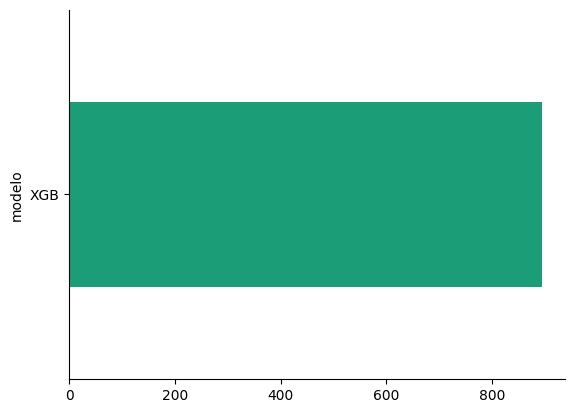

In [ ]:
df_preds_cluster_rf_kmeans['modelo'] = 'RF'
df_preds_cluster_xgb_kmeans['modelo'] = 'XGB'
df_preds_cluster_mlp_kmeans['modelo'] = 'MLP'
df_preds_cluster_lgbm_kmeans['modelo'] = 'LGBM'
df_preds_cluster_dt_kmeans['modelo'] = 'DT'

df_preds_cluster_rf_kmeans['metric_RMSE'] = np.sqrt(mean_squared_error(df_preds_cluster_rf_kmeans['udsVenta'], df_preds_cluster_rf_kmeans['udsVenta_pred']))
df_preds_cluster_xgb_kmeans['metric_RMSE'] = np.sqrt(mean_squared_error(df_preds_cluster_xgb_kmeans['udsVenta'], df_preds_cluster_xgb_kmeans['udsVenta_pred']))
df_preds_cluster_mlp_kmeans['metric_RMSE'] = np.sqrt(mean_squared_error(df_preds_cluster_mlp_kmeans['udsVenta'], df_preds_cluster_mlp_kmeans['udsVenta_pred']))
df_preds_cluster_lgbm_kmeans['metric_RMSE'] = np.sqrt(mean_squared_error(df_preds_cluster_lgbm_kmeans['udsVenta'], df_preds_cluster_lgbm_kmeans['udsVenta_pred']))
df_preds_cluster_dt_kmeans['metric_RMSE'] = np.sqrt(mean_squared_error(df_preds_cluster_dt_kmeans['udsVenta'], df_preds_cluster_dt_kmeans['udsVenta_pred']))

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_kmeans = pd.concat([
    df_preds_cluster_rf_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_xgb_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_mlp_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_lgbm_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_dt_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_kmeans = df_all_preds_kmeans.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por cluster
best_models_per_cluster = df_all_preds_kmeans.loc[df_all_preds_kmeans.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)


# Ordenamos por producto
best_models_per_cluster = best_models_per_cluster.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_cluster.to_csv('Mejores_Modelos_por_Cluster_Kmeans.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_cluster.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

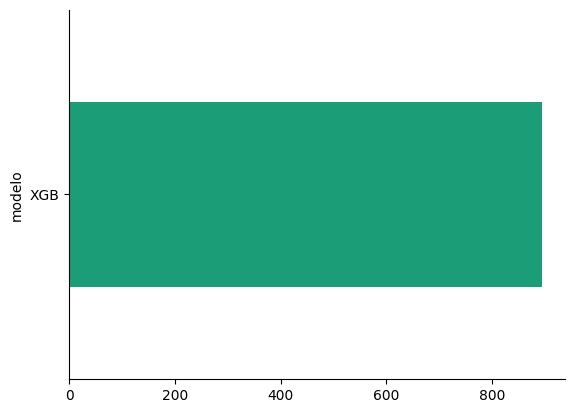

In [ ]:
df_preds_cluster_rf_gmm['modelo'] = 'RF'
df_preds_cluster_xgb_gmm['modelo'] = 'XGB'
df_preds_cluster_mlp_gmm['modelo'] = 'MLP'
df_preds_cluster_lgbm_gmm['modelo'] = 'LGBM'
df_preds_cluster_dt_gmm['modelo'] = 'DT'

df_preds_cluster_rf_gmm['metric_RMSE'] =  np.sqrt(mean_squared_error(df_preds_cluster_rf_gmm['udsVenta'], df_preds_cluster_rf_gmm['udsVenta_pred']))
df_preds_cluster_xgb_gmm['metric_RMSE'] =  np.sqrt(mean_squared_error(df_preds_cluster_xgb_gmm['udsVenta'], df_preds_cluster_xgb_gmm['udsVenta_pred']))
df_preds_cluster_mlp_gmm['metric_RMSE'] =  np.sqrt(mean_squared_error(df_preds_cluster_mlp_gmm['udsVenta'], df_preds_cluster_mlp_gmm['udsVenta_pred']))
df_preds_cluster_lgbm_gmm['metric_RMSE'] =  np.sqrt(mean_squared_error(df_preds_cluster_lgbm_gmm['udsVenta'], df_preds_cluster_lgbm_gmm['udsVenta_pred']))
df_preds_cluster_dt_gmm['metric_RMSE'] =  np.sqrt(mean_squared_error(df_preds_cluster_dt_gmm['udsVenta'], df_preds_cluster_dt_gmm['udsVenta_pred']))

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_gmm = pd.concat([
    df_preds_cluster_rf_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_xgb_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_mlp_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_lgbm_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_dt_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_gmm = df_all_preds_gmm.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por cluster
best_models_per_cluster_gmm = df_all_preds_gmm.loc[df_all_preds_gmm.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_cluster_gmm = best_models_per_cluster_gmm.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_cluster_gmm.to_csv('Mejores_Modelos_por_Cluster_GMM.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_cluster_gmm.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Exportación del modelo Naive para comparativa

In [ ]:
# Sacar RMSE por producto para el modelo naive
df_preds_test_naive = df_preds_test_naive.groupby(['producto'], as_index=False).agg({'metric_RMSE': 'first'})

# Renombrar columna RMSE
df_preds_test_naive_renamed = df_preds_test_naive.rename(columns={'metric_RMSE': 'RMSE'})


#Exportar a CSV
df_preds_test_naive_renamed.to_csv('Predicciones_Test_Naive_Modelo.csv', index=False)